In [ ]:
# Loading and inspecting dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
fossil_data = pd.read_csv('/content/drive/MyDrive/BT3041_Assignment 2_Dataset.csv')

# Display basic information
print(f"Dataset shape: {fossil_data.shape}")
print(fossil_data.head())

# Check for missing values
print(f"Missing values:\n{fossil_data.isnull().sum()}")

Dataset shape: (5498, 9)
   uranium_lead_ratio  carbon_14_ratio  radioactive_decay_series  \
0            0.738061         0.487707                  0.907884   
1            0.560096         0.341738                  1.121302   
2            0.424773         0.218493                  0.103855   
3            0.349958         0.704649                  0.383617   
4            0.886811         0.777494                  0.593254   

   stratigraphic_layer_depth  inclusion_of_other_fossils  \
0                      91.17                       False   
1                     165.44                       False   
2                     218.98                        True   
3                      51.09                        True   
4                     313.72                        True   

   isotopic_composition  fossil_size  fossil_weight    age  
0              0.915951        50.65         432.00  43523  
1              0.803968        48.85         353.29  44112  
2              0.79244

In [ ]:
# Summary statistics
print(fossil_data.describe())

       uranium_lead_ratio  carbon_14_ratio  radioactive_decay_series  \
count         5498.000000      5498.000000               5498.000000   
mean             0.488838         0.432231                  0.535231   
std              0.257185         0.235628                  0.288837   
min              0.000241         0.000244                  0.000076   
25%              0.296790         0.247020                  0.316775   
50%              0.475428         0.418902                  0.518653   
75%              0.661999         0.593708                  0.729653   
max              1.533270         1.000000                  1.527375   

       stratigraphic_layer_depth  isotopic_composition  fossil_size  \
count                5498.000000           5498.000000  5498.000000   
mean                  153.875369              0.941980    70.455324   
std                    87.163969              0.524836    37.139330   
min                     0.130000              0.000275     0.130000

In [ ]:
# Separate features and target
X = fossil_data.drop('age', axis=1)
y = fossil_data['age']

# Convert boolean to numeric {0,1} for the 'Inclusion of Other Fossils Column'
if 'inclusion_of_other_fossils' in X.columns and X['inclusion_of_other_fossils'].dtype == bool:
    X['inclusion_of_other_fossils'] = X['inclusion_of_other_fossils'].astype(int)

## Histogram to Visualise Age Distribution

Text(0.5, 0, 'Age')

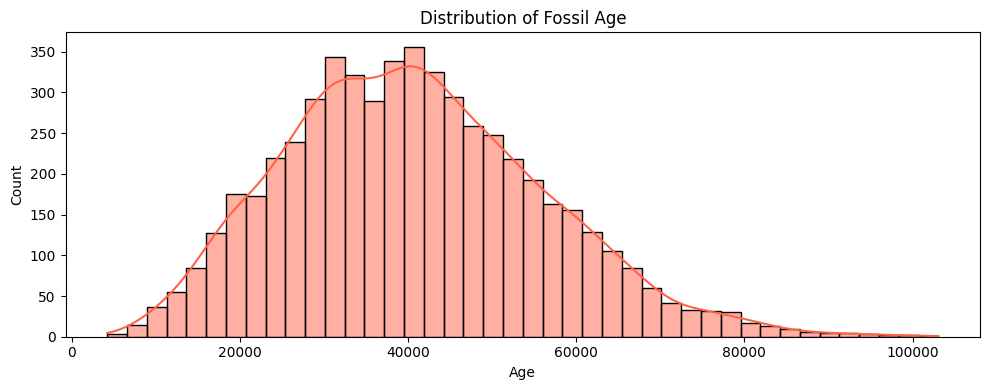

In [ ]:
# Visualize distribution of the target variable
fig, axes = plt.subplots(1, 1, figsize=(10, 4), tight_layout = True )

# Use sns.histplot
sns.histplot(fossil_data['age'], kde=True, ax=axes, color = 'tomato') # Call histplot using seaborn and specify the axes
axes.set_title('Distribution of Fossil Age')
axes.set_xlabel('Age')

## Scatter plots to vsualise Correlation of Raw Data

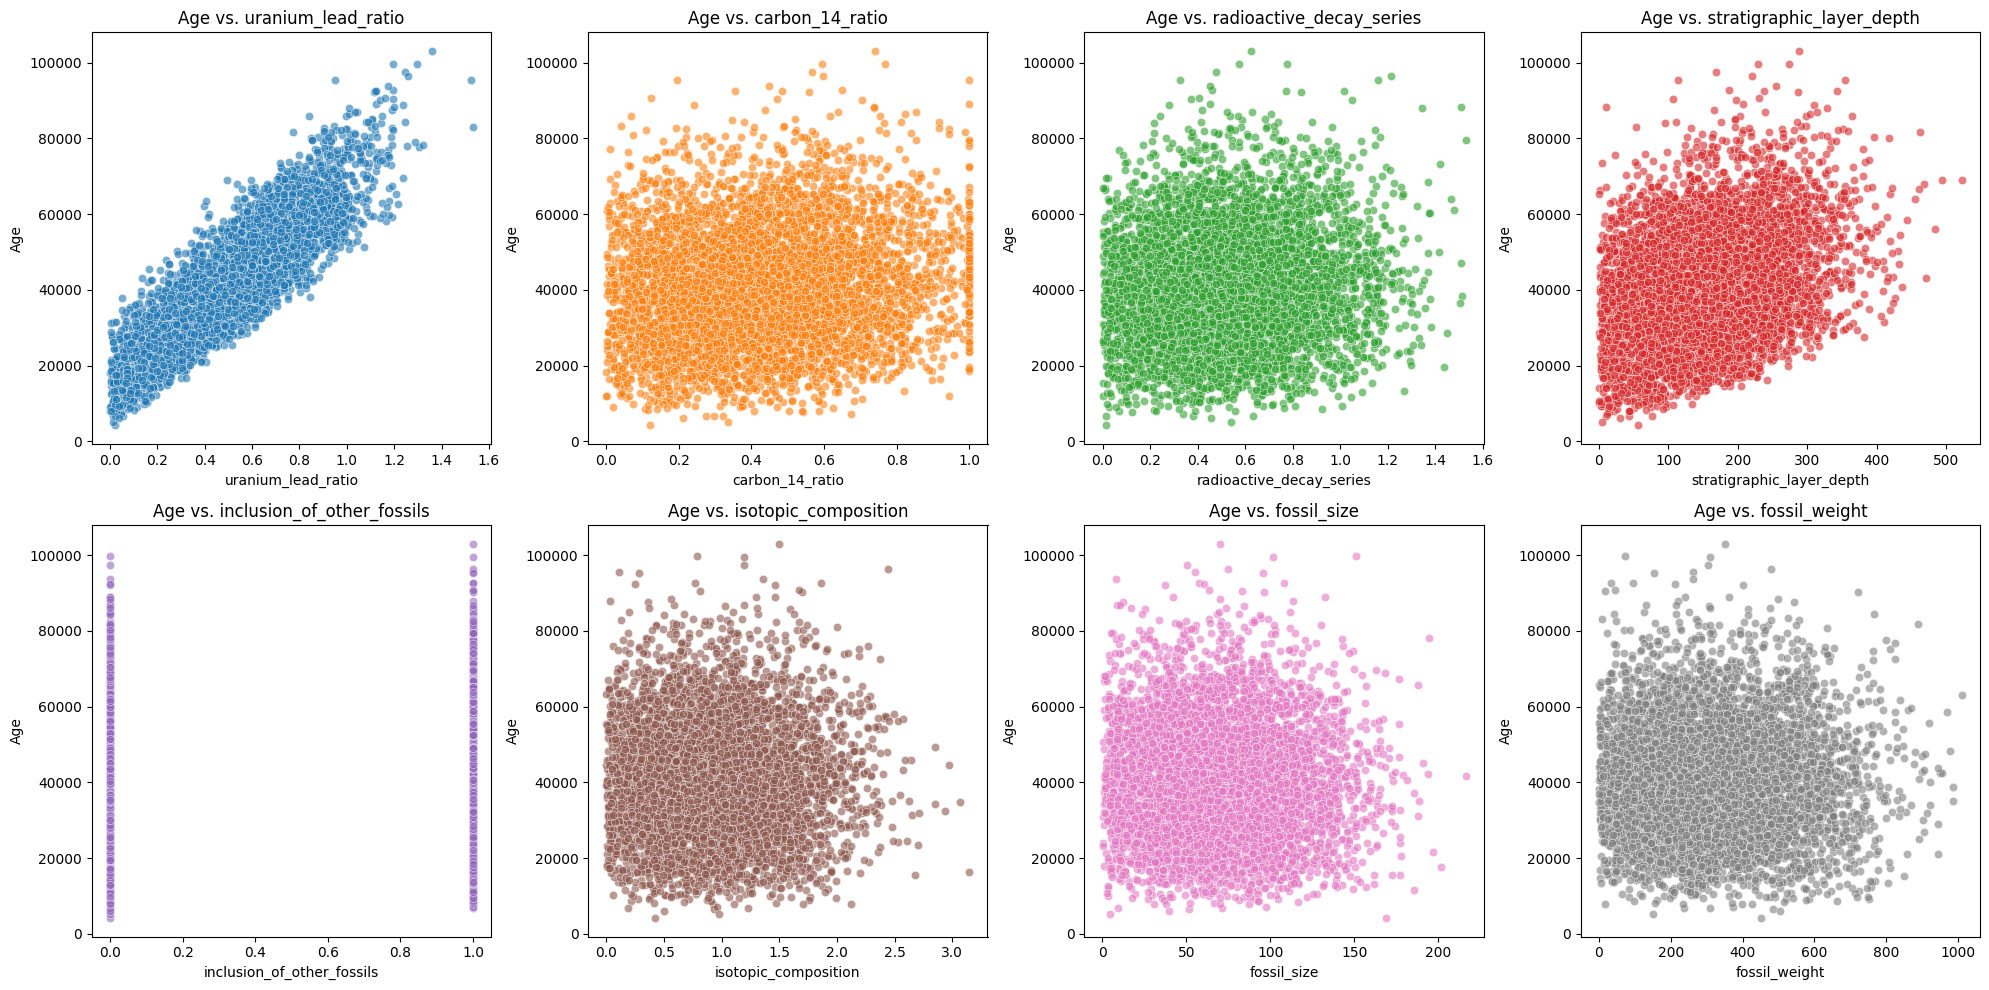

In [ ]:

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

custom_colors = sns.color_palette()
# print(custom_colors)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define the features to plot
features = ['uranium_lead_ratio', 'carbon_14_ratio', 'radioactive_decay_series',
            'stratigraphic_layer_depth', 'inclusion_of_other_fossils',
            'isotopic_composition', 'fossil_size', 'fossil_weight']

# Iterate through features and create scatter plots
for i, feature in enumerate(features):
  sns.scatterplot(x=feature, y='age', data= fossil_data, ax=axes[i], color = custom_colors [i], alpha = 0.6)
  axes[i].set_title(f'Age vs. {feature}')
  axes[i].set_xlabel(feature)
  axes[i].set_ylabel('Age')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Split Data into Training and Testing and then Z-score the data

In [ ]:
# Split 1: 80-20 split
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, test_size=0.2, random_state= 0)

# Split 2: 70-30 split
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X, y, test_size=0.3, random_state= 0)

print(f"80-20 split - Training set: {X_train_80.shape}, Test set: {X_test_80.shape}")
print(f"70-30 split - Training set: {X_train_70.shape}, Test set: {X_test_70.shape}")

# Feature scaling by Z-scoring
# create StandardScaler Objects
scaler_80 = StandardScaler()
scaler_70 = StandardScaler()

# transform the data
X_train_80_scaled = scaler_80.fit_transform(X_train_80) # finds mean and std dev of the data
X_test_80_scaled = scaler_80.transform(X_test_80) # Apply Z -score
X_train_70_scaled = scaler_70.fit_transform(X_train_70)
X_test_70_scaled = scaler_70.transform(X_test_70)

# verify if Z- scoring is correct: expect a mean near zero
print(f"Mean of scaled data : {np.mean(X_train_80_scaled)}, {X_train_80_scaled.shape}")


80-20 split - Training set: (4398, 8), Test set: (1100, 8)
70-30 split - Training set: (3848, 8), Test set: (1650, 8)
Mean of scaled data : -4.9679829751303046e-17, (4398, 8)


In [ ]:
# Defining function for repititive prints
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    return mse, rmse, mae, r2

## Cross Validate for Hyperparameter Optimisation

In [ ]:
# Linear Regression (No Regularization) - 80-20 split
lr_80 = LinearRegression()
lr_80.fit(X_train_80_scaled, y_train_80)
y_pred_lr_80 = lr_80.predict(X_test_80_scaled)
lr_80_metrics = evaluate_model(y_test_80, y_pred_lr_80, "Linear Regression (80-20 split)")
print('\n')

# Linear Regression (No Regularization) - 70-30 split
lr_70 = LinearRegression()
lr_70.fit(X_train_70_scaled, y_train_70)
y_pred_lr_70 = lr_70.predict(X_test_70_scaled)
lr_70_metrics = evaluate_model(y_test_70, y_pred_lr_70, "Linear Regression (70-30 split)")
print('\n')

# Ridge Regression (L2 Regularization) - 80-20 split
ridge_80 = Ridge(alpha=1.0)  # Default alpha value
ridge_80.fit(X_train_80_scaled, y_train_80)
y_pred_ridge_80 = ridge_80.predict(X_test_80_scaled)
ridge_80_metrics = evaluate_model(y_test_80, y_pred_ridge_80, "Ridge Regression (80-20 split)")
print( '\n')

# Ridge Regression (L2 Regularization) - 70-30 split
ridge_70 = Ridge(alpha=1.0)  # Default alpha value
ridge_70.fit(X_train_70_scaled, y_train_70)
y_pred_ridge_70 = ridge_70.predict(X_test_70_scaled)
ridge_70_metrics = evaluate_model(y_test_70, y_pred_ridge_70, "Ridge Regression (70-30 split)")
print('\n')

Linear Regression (80-20 split) Performance Metrics:
MSE: 18647606.85
RMSE: 4318.29
MAE: 3525.10
R²: 0.9192


Linear Regression (70-30 split) Performance Metrics:
MSE: 18593053.64
RMSE: 4311.97
MAE: 3547.56
R²: 0.9199


Ridge Regression (80-20 split) Performance Metrics:
MSE: 18647059.06
RMSE: 4318.22
MAE: 3525.10
R²: 0.9192


Ridge Regression (70-30 split) Performance Metrics:
MSE: 18593143.06
RMSE: 4311.98
MAE: 3547.64
R²: 0.9199




Best alpha: 1.611414
Minimum MSE: 18647504.85


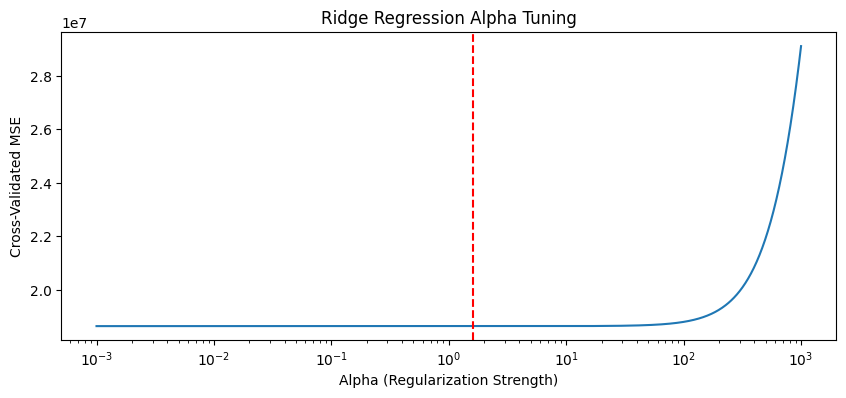

Best alpha: 1.156280
Minimum MSE: 18671983.15


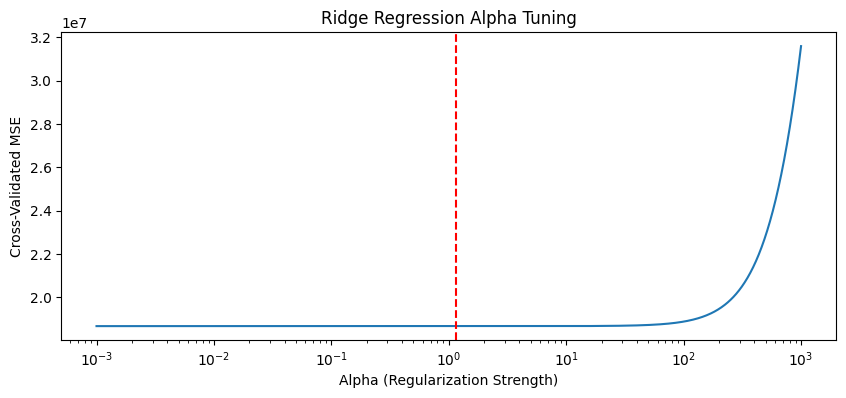

In [ ]:
# 5-fold cross-validation for tuning alpha
# Using a coarse time step, the best alpha was found to lie between

def tune_alpha_with_cv(X_train, y_train, alphas=np.logspace(-3, 3, 1000)): # using log space since range of alpha is wide
    cv_scores = []

    for alpha in alphas:
        ridge = Ridge(alpha=alpha) # ridge reg model with alpha
        scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_scores.append(np.mean(np.abs(scores)))

    best_alpha = alphas[np.argmin(cv_scores)]
    min_score = np.min(cv_scores)

    print(f"Best alpha: {best_alpha:.6f}")
    print(f"Minimum MSE: {min_score:.2f}")

    plt.figure(figsize=(10, 4))
    plt.semilogx(alphas, cv_scores)
    plt.xlabel('Alpha (Regularization Strength)')
    plt.ylabel('Cross-Validated MSE')
    plt.title('Ridge Regression Alpha Tuning')
    plt.axvline(best_alpha, color='r', linestyle='--')
    plt.show()

    return best_alpha, min_score

# Coarse Tuning alpha for 80-20 split
best_coarse_alpha_80, _ = tune_alpha_with_cv(X_train_80_scaled, y_train_80)

# Course Tuning alpha for 70-30 split
best_coarse_alpha_70, _ = tune_alpha_with_cv(X_train_70_scaled, y_train_70)

Best alpha for 80-2- split 
Best alpha: 1.609610
Minimum MSE: 18647504.85


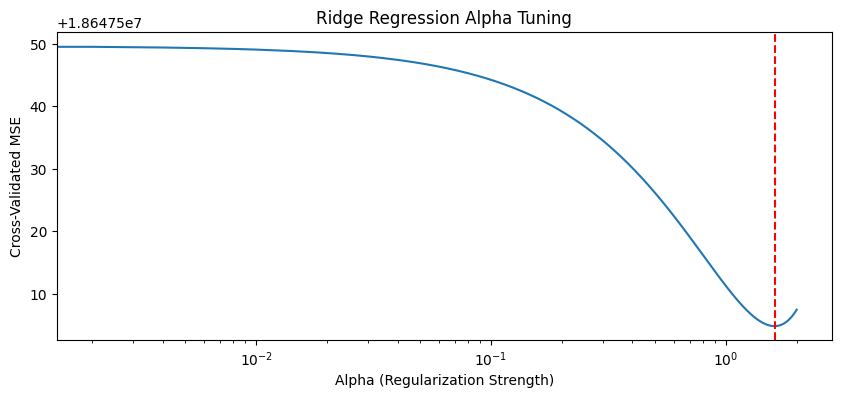

Best alpha: 1.155155
Minimum MSE: 18671983.15


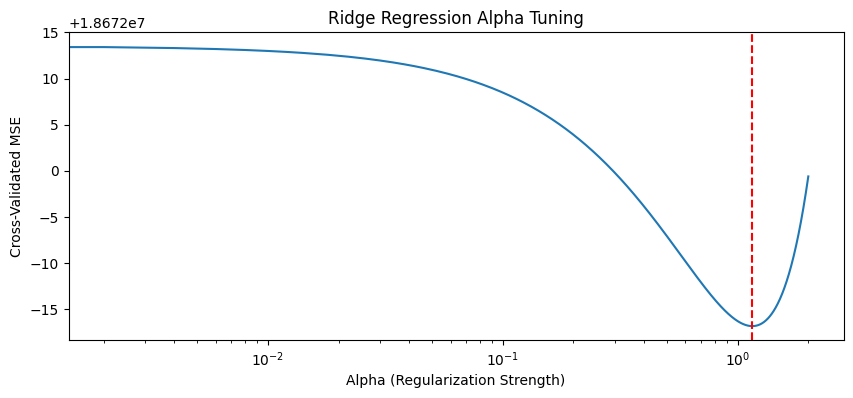

In [ ]:
# Fine tune since npw rough range is (0,2)
print('Best alpha for 80-20 split ')
best_alpha_80, _ = tune_alpha_with_cv(X_train_80_scaled, y_train_80, alphas=np.linspace(0, 2, 1000))
best_alpha_70, _ = tune_alpha_with_cv(X_train_70_scaled, y_train_70, alphas=np.linspace(0, 2, 1000))

## Using Grid search since the dataset is small

In [ ]:
# Grid search cross-validation
param_grid = {'alpha': np.linspace(0, 2, 100)}
grid_search = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# Best Alpha for Ridge
# For 80-20 split: Ridge
grid_search.fit(X_train_80_scaled, y_train_80)
print(f"Best alpha from Grid Search (80-20): {grid_search.best_params_['alpha']:.6f}")
print(f"Best CV score: {-grid_search.best_score_:.2f}")

# For 70-30 split : Ridge
grid_search.fit(X_train_70_scaled, y_train_70)
print(f"Best alpha from Grid Search (70-30): {grid_search.best_params_['alpha']:.6f}")
print(f"Best CV score: {-grid_search.best_score_:.2f}")


Best alpha from Grid Search (80-20): 1.616162
Best CV score: 18647504.85
Best alpha from Grid Search (70-30): 1.151515
Best CV score: 18671983.15


## Optimised Linear Models

In [ ]:
# Create optimized Ridge models
optimized_ridge_80 = Ridge(alpha=best_alpha_80)
optimized_ridge_80.fit(X_train_80_scaled, y_train_80)
y_pred_optimized_ridge_80 = optimized_ridge_80.predict(X_test_80_scaled)
optimized_ridge_80_metrics = evaluate_model(y_test_80, y_pred_optimized_ridge_80, "Optimized Ridge Regression (80-20 split)")
print('\n')

optimized_ridge_70 = Ridge(alpha=best_alpha_70)
optimized_ridge_70.fit(X_train_70_scaled, y_train_70)
y_pred_optimized_ridge_70 = optimized_ridge_70.predict(X_test_70_scaled)
optimized_ridge_70_metrics = evaluate_model(y_test_70, y_pred_optimized_ridge_70, "Optimized Ridge Regression (70-30 split)")
#print('\n')


Optimized Ridge Regression (80-20 split) Performance Metrics:
MSE: 18646736.03
RMSE: 4318.19
MAE: 3525.10
R²: 0.9192


Optimized Ridge Regression (70-30 split) Performance Metrics:
MSE: 18593159.49
RMSE: 4311.98
MAE: 3547.65
R²: 0.9199


In [ ]:
# Collect all metrics for comparison
models = [
    "Linear Regression (80-20)",
    "Linear Regression (70-30)",
    "Ridge Regression (80-20)",
    "Ridge Regression (70-30)",
    "Optimized Ridge (80-20)",
    "Optimized Ridge (70-30)"
]


metrics = [
    lr_80_metrics, # 80-20 split.
    lr_70_metrics, # 70-3- split
    ridge_80_metrics, # ridge 80-20 default alpha
    ridge_70_metrics, # ridge 70-30 split default alpha
    optimized_ridge_80_metrics, # ridge 80-20 split, optimised alpha
    optimized_ridge_70_metrics # ridge 70-30 split, optimised alpha
]

# Create a DataFrame for easy Display comparison
metrics_df = pd.DataFrame({
    'Model': models,
    'MSE': [m[0] for m in metrics],
    'RMSE': [m[1] for m in metrics],
    'MAE': [m[2] for m in metrics],
    'R²': [m[3] for m in metrics]
})

print("Model Comparison:")
print(metrics_df)

Model Comparison:
                       Model           MSE         RMSE          MAE        R²
0  Linear Regression (80-20)  1.864761e+07  4318.287491  3525.103738  0.919156
1  Linear Regression (70-30)  1.859305e+07  4311.966330  3547.562942  0.919900
2   Ridge Regression (80-20)  1.864706e+07  4318.224063  3525.098103  0.919159
3   Ridge Regression (70-30)  1.859314e+07  4311.976699  3547.640389  0.919900
4    Optimized Ridge (80-20)  1.864674e+07  4318.186660  3525.100799  0.919160
5    Optimized Ridge (70-30)  1.859316e+07  4311.978604  3547.652402  0.919900


## Plotting the best model : Optimised Ridge with 70 30 split

Text(0.5, 1.0, 'Actual vs. Predicted Age (70-30: Optimized Ridge Regression)')

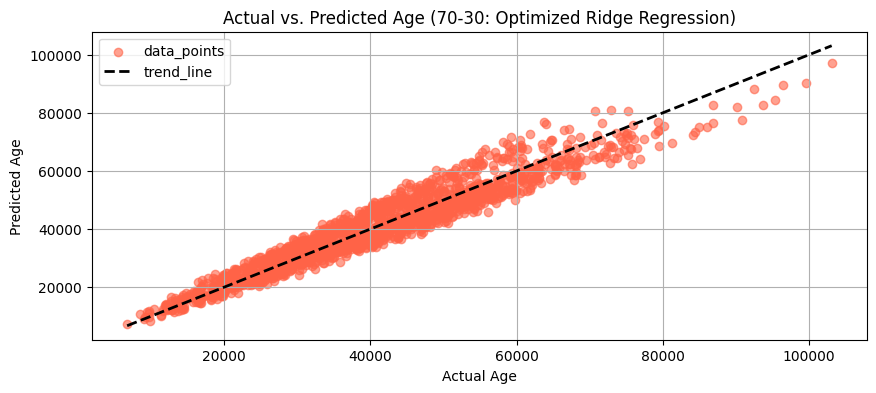

In [ ]:
plt.figure(figsize = (10,4))

plt.scatter(y_test_70, y_pred_optimized_ridge_70, color = 'tomato', alpha = 0.6, label = 'data_points')
plt.plot([y_test_70.min(), y_test_70.max()], [y_test_70.min(), y_test_70.max()], 'k--', lw=2, label = 'trend_line')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.grid(True) # for easy visualsation
plt.title('Actual vs. Predicted Age (70-30: Optimized Ridge Regression)')